# <center>Network Science</center>

Home Assignment #4: Network Embeddings

#### <hr /> General Information

**Due Date:** 15.06.2020 21:00 <br>
**Late submission policy: No late submission!** <br>


Please send your reports to <iakarpov@hse.ru> with message subject of the following structure: <br>
**[HSE SNA Magolego 2020] *{LastName}* *{First Name}* HW_4*

Support your computations with figures and comments. <br>
If you are using IPython Notebook you may use this file as a starting point of your report.

## Problems

### Task 1. Generating N2V Embedding
Use any existing network from our [classes](https://dl.dropboxusercontent.com/s/8eo1sjfhu5spb0f/vk.tsv?dl=1) or your couse project. <br>
Use `cores` method if your initial network is too big. <br>

In [20]:
import scipy.sparse as sp
import pandas as pd
import urllib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import warnings; warnings.simplefilter('ignore')
g = nx.read_adjlist('VK.data')

In [21]:
core_subgraph = nx.k_core(g, k=20) #k - core level
print(core_subgraph.number_of_nodes())
print(g.number_of_nodes())
G = core_subgraph

338
2113


In [22]:
file_path = "VK.data"
df = pd.read_csv(file_path, header=None, decimal=",", delimiter=" ", names=['ID', 'neighbourID', 'edge_weight'])[1:]
print(len(df))
df.sample(5)

2053


,ID,neighbourID,edge_weight
862,VK_33071282,VK_19846711,VK_36455975
1308,VK_96120811,VK_14666092,VK_21716878
1237,VK_17905974,VK_31150912,VK_110248399
1627,VK_377960025,VK_380906462,VK_400978758
1218,VK_16500601,VK_20290087,VK_308917697


In [23]:
import node2vec
from node2vec import Node2Vec
from gensim.models import Word2Vec

In [24]:
g = nx.read_adjlist('VK.data')

print("Graph is created!!")    
print("Number of nodes: {:,d}".format(len(g.nodes())))
print("Number of edges: {:,d}".format(g.size()))

Graph is created!!
Number of nodes: 2,113
Number of edges: 25,737


In [25]:
np.random.seed(0) 
adj_sparse = nx.to_scipy_sparse_matrix(g)

In [26]:
g_train = nx.from_scipy_sparse_matrix(adj_sparse) 

In [27]:
print("Total nodes:", adj_sparse.shape[0])
print("Total edges:", int(adj_sparse.nnz/2)) 

Total nodes: 2113
Total edges: 25737


1.1. Train Node2Vec model with **two** different p and q parameters

In [28]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [29]:
node2vec = Node2Vec(g_train, dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS, workers=WORKERS)
model = node2vec.fit(window=WINDOW_SIZE, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 2113/2113 [00:22<00:00, 93.90it/s] 


In [30]:
P = 2 
Q = 0,25
WINDOW_SIZE = 10 
NUM_WALKS = 10 
WALK_LENGTH = 80 
DIMENSIONS = 128 
DIRECTED = False
WORKERS = 8 
ITER = 1 

In [31]:
node2vec = Node2Vec(g_train, dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS, workers=WORKERS)
model = node2vec.fit(window=WINDOW_SIZE, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 2113/2113 [00:22<00:00, 95.13it/s] 


### Task 2. Link Prediction
2.1. Perform Link Prediction through Node2Vec. Evaluate accuracy of prediction. Describe results. <br>

In [32]:
graph = nx.Graph()

In [33]:
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_matrix(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print(edge)
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print('creating false train edges...')

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false



In [34]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

# Preprocessing/Train-Test Split

In [35]:
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [36]:
# Inspect train/test split
print("Total nodes:", adj_sparse.shape[0])
print("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 2113
Total edges: 25737
Training edges (positive): 15443
Training edges (negative): 15443
Validation edges (positive): 2573
Validation edges (negative): 2573
Test edges (positive): 7721
Test edges (negative): 7721


In [37]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

# Adamic-Adar

It predict links in a social network, according to the amount of shared links between two nodes. It is defined as the sum of the inverse logarithmic degree centrality of the neighbours shared by the two nodes.

In [38]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj_train.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [39]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Adamic-Adar Test ROC score: ', str(aa_roc))
print('Adamic-Adar Test AP score: ', str(aa_ap))

Adamic-Adar Test ROC score:  0.9532214507030339
Adamic-Adar Test AP score:  0.9539806749975781


# Jaccard Coefficient

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It's a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations

In [40]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(adj_train.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

In [41]:
# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print('Jaccard Coefficient Test ROC score: ', str(jc_roc))
print('Jaccard Coefficient Test AP score: ', str(jc_ap))

Jaccard Coefficient Test ROC score:  0.9440899136158666
Jaccard Coefficient Test AP score:  0.9319001779135971


# Preferential Attachment

The node degrees follow a power law distribution in many real world networks, also known as scale-free networks. The preferential attachment score is derived from results in the study of scale-free networks, and measures the interaction between a pair of nodes as the product of their degrees. Therefore, this metric prioritizes links between pairs of high-degree nodes.

In [42]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(adj_train.shape)
for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [43]:
# Calculate ROC AUC and Average Precision
pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)

print('Preferential Attachment Test ROC score: ', str(pa_roc))
print('Preferential Attachment Test AP score: ', str(pa_ap))

Preferential Attachment Test ROC score:  0.8479984455287825
Preferential Attachment Test AP score:  0.8673059296482258


### Task 3. Node clustering
3.1. Perform Node classification through Node2Vec. How does it compare to the community detection from HW2 ? <br>

# Node classification through Node2Vec compared to the community detection

The Node2Vec algorithm continues to apply the spectral clustering method to calculate the similarity among any two node embeddings and finish the community detection in the given networks. This algorithm provides a high-quality and accuracy performance in a wide range of data sets.

In [46]:
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

In [47]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)

In [48]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [49]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


In [50]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [51]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

In [52]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [53]:
from sklearn.manifold import TSNE

In [54]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

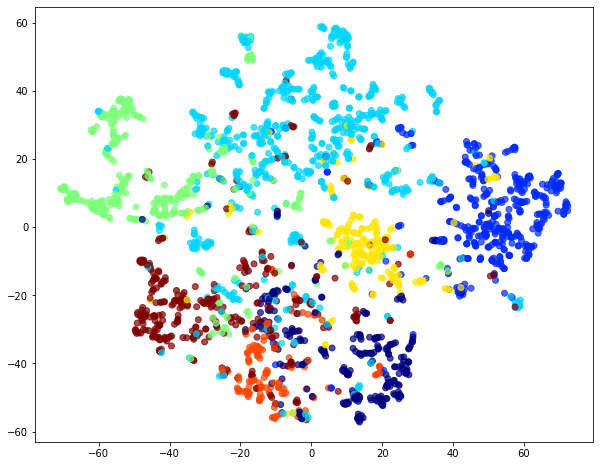

In [55]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

From Node classification through Node2Vec we can see 5 clusters among any two node embeddings in the given networks.